# pip-installs and load libraries

In [1]:
!pip install tensorflow
!pip install patchify
!pip install segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.4 MB/s eta 0:00:00


In [2]:
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm
import tensorflow as tf
import keras
import albumentations as A
import torch
import csv
from torch import nn
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
from random import randrange, shuffle
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from torchvision import transforms
from torchvision.transforms.functional import rotate
import torchvision
import cv2
import time, glob
import PIL
import pandas as pd 
import torch.utils.data as data
import csv
import glob
import os
from sklearn.model_selection import train_test_split
import pickle
from tqdm.notebook import tqdm
from PIL import Image
from patchify import patchify, unpatchify


os.environ['CUDA_VISIBLE_DEVICES'] = '0'
ROOT_DIR = "../input/airbus-ship-detection"
test_folder = os.path.join(ROOT_DIR, 'test_v2')
train_folder = os.path.join(ROOT_DIR, 'train_v2')

env: SM_FRAMEWORK=tf.keras


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Segmentation Models: using `tf.keras` framework.


In [3]:
for i in tqdm(range(10)):
    print(i)

  0%|          | 0/10 [00:00<?, ?it/s]

0
1
2
3
4
5
6
7
8
9


## Check file sizes

In [ ]:
file_sizes = []
for filename in tqdm(os.listdir(train_folder)):
    file_sizes.append(os.stat(os.path.join(train_folder, filename)).st_size / 1024)

In [ ]:
np.mean(file_sizes), np.std(file_sizes), np.min(file_sizes), np.max(file_sizes)

In [ ]:
len(list(filter(lambda x: x < 50, file_sizes)))

## Finding

No empty files

# EDA

## 1. Check image shapes, to confirm they are all 768x768x3

In [7]:
for folder in [test_folder, train_folder]:
    for filename in tqdm(os.listdir(folder)):
        img = PIL.Image.open(os.path.join(folder, filename))
        if img.size != (768, 768):
            print(f"{filename} in {folder} has size {img.size}")

  0%|          | 0/15606 [00:00<?, ?it/s]

  0%|          | 0/192556 [00:00<?, ?it/s]

## 2. Ships distribution

Images: 192556 
Ships:  81723
Images with ships:    0.22 (42556)
Images with no ships: 0.78 (150000)


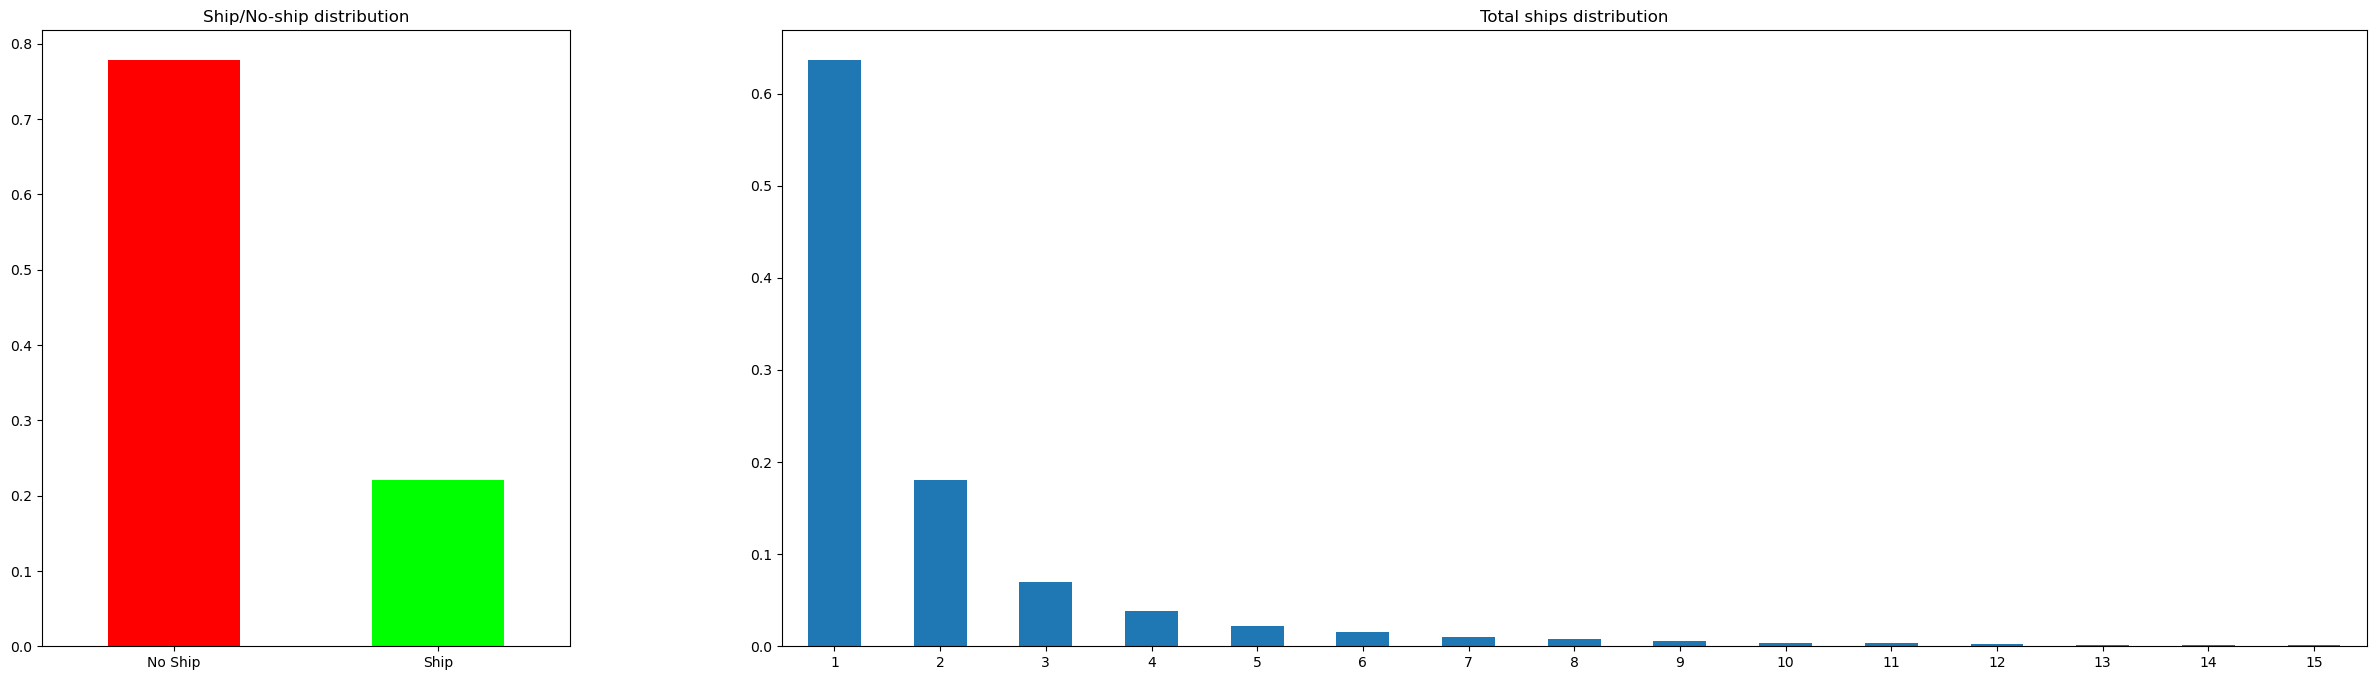

In [8]:
def load_df(file="train"):
    df = pd.read_csv(f"/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv")
    df['HasShip'] = df['EncodedPixels'].notnull()
    df = df.groupby("ImageId").agg({'HasShip': ['first', 'sum']}) # counts amount of ships per image, sets ImageId to index
    df.columns = ['HasShip', 'TotalShips']
    return df

def show_df(df):
    """
    Prints and displays the ship/no-ship ratio and the ship count distribution of df
    """
    total = len(df)
    ship = df['HasShip'].sum()
    no_ship = total - ship
    total_ships = int(df['TotalShips'].sum())
        
    print(f"Images: {total} \nShips:  {total_ships}")
    print(f"Images with ships:    {round(ship/total,2)} ({ship})")
    print(f"Images with no ships: {round(no_ship/total,2)} ({no_ship})")
    
    _, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 8), gridspec_kw = {'width_ratios':[1, 3]})
    
    # Plot ship/no-ship with a bar plot
    ship_ratio = df['HasShip'].value_counts() / total
    ship_ratio = ship_ratio.rename(index={True: 'Ship', False: 'No Ship'})
    ship_ratio.plot.bar(ax=axes[0], color=['red', 'lime'], rot=0, title="Ship/No-ship distribution");
    
    # Plot TotalShips distribution with a bar plot
    total_ships_distribution = df.loc[df['HasShip'], 'TotalShips'].value_counts().sort_index() / ship
    total_ships_distribution.plot(kind='bar', ax=axes[1], rot=0, title="Total ships distribution");

df_train = load_df("train")
show_df(df_train)

## Finding 1

### **22%** of train images contains ships and **>60%** of them contains only **1** ship. Therefore high chance that we have pixels-imbalance

In [9]:
df = pd.read_csv("../input/airbus-ship-detection/train_ship_segmentations_v2.csv", index_col=0).dropna()
display(df.head())

,EncodedPixels
ImageId,
000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...


## 3. Patch image into squares, same ship's distribution analysis 

In [10]:
def rle_to_pixels(rle_code):
    '''
    Transforms a RLE code string into a list of pixels of a (768, 768) canvas
    '''
    rle_code = [int(i) for i in rle_code.split()]
    pixels = [(pixel_position % 768, pixel_position // 768) 
                 for start, length in list(zip(rle_code[0:-1:2], rle_code[1::2])) 
                 for pixel_position in range(start, start + length)]
    return pixels

def show_pixels_distribution(df):
    """
    Prints the amount of ship and no-ship pixels in the df
    """
    # Total images in the df
    n_images = df['ImageId'].nunique() 
    
    # Total pixels in the df
    total_pixels = n_images * 768 * 768 

    # Keep only rows with RLE boxes, transform them into list of pixels, sum the lengths of those lists
    ship_pixels = df['EncodedPixels'].dropna().apply(rle_to_pixels).str.len().sum() 

    ratio = ship_pixels / total_pixels
    print(f"Ship: {round(ratio, 3)} ({ship_pixels})")
    print(f"No ship: {round(1 - ratio, 3)} ({total_pixels - ship_pixels})")
    
    
# rle_to_pixels(' '.join(df['EncodedPixels']['000194a2d.jpg']))[0:3]
df_train = pd.read_csv(f"/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv")

show_pixels_distribution(df_train)
del df_train

Ship: 0.001 (128092863)
No ship: 0.999 (113446057281)


## Finding

There is pixels-imbalance - ships are 0.1% of all pixels. To mitigate that at the data level we may

1) Remove images with small portion of ship pixels

2) Crop or resize images

At the model level we may take an advantage from binary focal loss

In [11]:
load_img = lambda filename: np.array(PIL.Image.open(os.path.join(train_folder, filename)))

def quadr_distibution(df, step=256):
    total_area = 0
    total_ships_area = 0
    total_quadr_ship = 0
    total_quadr = 0
    
    mask = np.zeros((768, 768))
    print(df.shape)
    new_paths = []
    bad_labeling = []
    for img_id in tqdm(np.unique(df.index)):
        img = load_img(img_id)
        mask = np.zeros((768, 768))
        masks = rle_to_pixels(' '.join(df['EncodedPixels'][img_id]))
        try:
            mask[tuple(zip(*masks))] = 1
            patch_img = patchify(img, (step,step, 3), step=step)
            patch_mask = patchify(mask, (step,step), step=step)
            total_quadr += (img.shape[0] // step) * (img.shape[1] // step)
            for i in range(img.shape[0] // step):
                for j in range(img.shape[1] // step):
                    sm = patch_mask[i][j].sum()
                    if sm != 0:
                        new_paths.append((img_id, i, j))
                        total_quadr_ship += 1
                        total_area += step * step
                        total_ships_area += sm
        except:
            print(f'bad encoding at {img_id}')
            bad_labeling.append(img_id)
        
    print(f"ships: {round(total_ships_area / total_area, 3)}")
    print(f"no-ships: {round((total_area - total_ships_area) / total_area, 3)}")
    print(f"quadr_ship: {total_quadr_ship}, ratio = {round(total_quadr_ship / total_quadr, 3)}")
    return new_paths
six_paths = []
six_paths = quadr_distibution(df.dropna()[:], 128)

(81723, 1)


  0%|          | 0/42556 [00:00<?, ?it/s]

bad encoding at 331ca6f3b.jpg
bad encoding at 4ed854632.jpg
bad encoding at b273e414e.jpg
bad encoding at b3955e008.jpg
bad encoding at d50ddd1e3.jpg
bad encoding at e698a6a67.jpg
ships: 0.041
no-ships: 0.959
quadr_ship: 93504, ratio = 0.061


## Finding 2

There are several bad encoding - index is out of the image, I skip them. Then I try to split image into 6x6 squares each 128x128, and check ship-pixels distribution there. Once I count only images with ships I get **4.1%** of ship pixels. This has to a) speed up model training; b) Help with convergance

In [12]:
print(len(six_paths))
with open('six_paths.pkl', 'wb') as f:
    pickle.dump(six_paths, f)

93504


## 4. Conclusion at EDA part

# Data preparation

## 1. Data loaders and train/val split

For proper train-valid split I split them by inage_path, so no overlap (any hidden information) between train and validation. Proportion is **95%/5%**.

In [13]:
with open('/kaggle/input/six-paths-93504/six_paths (1).pkl', 'rb') as f:
    six_paths = pickle.load(f)
print(len(six_paths))

93504


In [14]:
all_paths = [x[0] for x in six_paths]
unique_imgs = np.unique(all_paths)

percentile = 0.05
unique_train, unique_val = train_test_split(unique_imgs, test_size=percentile, random_state=42)

train_imgs, val_imgs = [], []
for path in tqdm(six_paths):
    if path[0] in unique_val:
        val_imgs.append(path)
    else:
        train_imgs.append(path)
len(train_imgs), len(val_imgs)

  0%|          | 0/93504 [00:00<?, ?it/s]

(88924, 4580)

## Finding

I found out that there are images (squares) in train that has small portion of ship-pixels on it. So basically I decide to filter out squares that contains **<30** ship-pixels. Also I created a set with **11k** training samples that has **>=50** pixels (I will use it during model experiments)

In [15]:
min_area = 30
areas = []
cnt_removed = 0
new_train = []
for path in tqdm(train_imgs):
    pxls = rle_to_pixels(' '.join(df['EncodedPixels'][path[0]]))
    mask = np.zeros((768, 768))
    mask[tuple(zip(*pxls))] = 1
    step = 128
    patch_mask = patchify(mask, (step,step), step=step)
    area = patch_mask[path[1]][path[2]].sum()
    
    if area < min_area:
        cnt_removed += 1
    else:
        new_train.append(path)
    if area == 0:
        print(path)
    areas.append(area)
print(cnt_removed, cnt_removed / len(train_imgs))

  0%|          | 0/88924 [00:00<?, ?it/s]

31457 0.3537515181503306


In [17]:
train_small_amount = False
if train_small_amount:
    new_imgs = list(filter(lambda pp: pp[1] >= 0.1 * 128 * 128, zip(train_imgs, areas)))
    len(new_imgs)
    train_imgs = [x[0] for x in new_imgs]

In [18]:
train_imgs = new_train
len(train_imgs)

57467

In [19]:
print(len(areas))
with open('areas.pkl', 'wb') as f:
    pickle.dump(areas, f)

88924


In [20]:
print(len(val_imgs))
with open('val_imgs.pkl', 'wb') as f:
    pickle.dump(val_imgs, f)
print(len(train_imgs))
with open('train_imgs.pkl', 'wb') as f:
    pickle.dump(train_imgs, f)

4580
57467


In [21]:
with open('/kaggle/input/airbus-loads/train_imgs.pkl', 'rb') as f:
    train_imgs = pickle.load(f)
with open('/kaggle/input/airbus-loads/val_imgs.pkl', 'rb') as f:
    val_imgs = pickle.load(f)
len(train_imgs), len(val_imgs)

(57467, 4580)

In [24]:
# Check that all masks in train contains >= 30 ship px
used_id = {}
for path in tqdm(train_imgs):
    if path in used_id.keys():
        continue
    used_id[path] = "used"
    qi, qj = path[1:]
    pxls = rle_to_pixels(' '.join(df['EncodedPixels'][path[0]]))
    mask = np.zeros((768, 768))
    mask[tuple(zip(*pxls))] = 1
    step = 128
    patch_mask = patchify(mask, (step,step), step=step)
    if patch_mask[qi][qj].sum() < 30:
        print(f"Bad at {path}")

  0%|          | 0/57467 [00:00<?, ?it/s]

To make it convenient I introduce custom dataset and dataloader which is suitable with [segmentation_models](https://github.com/qubvel/segmentation_models) library

In [25]:
class Dataloder(keras.utils.Sequence):
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):    
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        return batch
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

In [26]:
class AirbusShipDataset():
    
    def __init__(self, root_paths, paths, labels_csv=None, transform=None,train=True,size=768,preprocessing_fn=None, augmentation=None):
        self.root_paths = root_paths
        self.paths = paths

        if labels_csv:
            self.masks = pd.read_csv(labels_csv)
            self.masks = self.masks[~self.masks.EncodedPixels.isna()] 
        else:
            self.masks = pd.DataFrame()
        self.transform = transform
        self.train = train
        self.size = size

        self.preprocessing_fn = preprocessing_fn
        self.augmentation = augmentation

    def __len__(self):
        return len(self.paths)
    
    def getranditem(self):
        ImageId, qi, qj = self.paths[randrange(self.__len__())]
         
        all_masks = np.zeros((768, 768))
        img_masks = rle_to_pixels(' '.join(df['EncodedPixels'][ImageId]))
        all_masks[tuple(zip(*img_masks))] = 1
        
        img_path = f"{ROOT_DIR}/{self.root_paths}/{ImageId}"
        image = cv2.imread(img_path)

        step = 128
        patch_img = patchify(image, (step,step, 3), step=step)
        patch_mask = patchify(all_masks, (step,step), step=step)
        return patch_img[qi][qj][0], patch_mask[qi][qj]
    
    def __getitem__(self, idx):
        ImageId, qi, qj = self.paths[idx]

        all_masks = np.zeros((768, 768))
        img_masks = rle_to_pixels(' '.join(df['EncodedPixels'][ImageId]))
        all_masks[tuple(zip(*img_masks))] = 1

        img_path = f"{ROOT_DIR}/{self.root_paths}/{ImageId}"
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        
        step = 128
        patch_img = patchify(image, (step,step, 3), step=step)
        patch_mask = patchify(all_masks, (step,step), step=step)
        image, all_masks = patch_img[qi][qj][0], patch_mask[qi][qj]
                
        if self.augmentation and self.train:
            sample = self.augmentation(image=image, mask=all_masks)
            image, all_masks = sample['image'], sample['mask']
        
        if not self.train:
            x =  image.transpose([2, 0, 1]).astype(np.float32)
            x = x.astype(np.float32)
            tf.cast(x, tf.float32)
            return x, ImageId
        
        if self.preprocessing_fn is not None:
            image = np.array(image)
            sample = self.preprocessing_fn(image = image, mask=all_masks)
            image, all_masks = sample['image'], sample['mask']
        
        image = image.astype(np.float32)
        all_masks = all_masks.astype(np.float32)
        tf.cast(image, tf.float32)
        tf.cast(all_masks, tf.float32)     
        return image, all_masks

## 2. Check training samples

For training set I introduce basic augmentation - Flip, Rotate, Noise, Blur, Contrast - without Scaling / Shifting / Crops. 

In [27]:
BACKBONE = 'efficientnetb3'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [28]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(scale_limit=0.0, rotate_limit=120, shift_limit=0.0, p=0.5),
#         A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
#         A.RandomCrop(height=320, width=320, always_apply=True),
        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),
        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),
        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),
        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    test_transform = []
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

In [29]:
trainAirbusShipDataset = AirbusShipDataset("train_v2",
                                           train_imgs[:], 
                                           f"{ROOT_DIR}/train_ship_segmentations_v2.csv", 
                                           transform = None,
                                           train=True,
                                           preprocessing_fn=get_preprocessing(preprocess_input),
                                           augmentation=get_training_augmentation()
                                          )

/opt/conda/lib/python3.10/site-packages/albumentations/imgaug/transforms.py:261: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/opt/conda/lib/python3.10/site-packages/albumentations/imgaug/transforms.py:384: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1149: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/albumentations/imgaug/transforms.py:231: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/opt/conda/lib/python3.10/site-packages/alb

In [30]:
def rle_encoder(image_mask):
    
    """ Change from 2d to 1d (x_size*y_size, 1) 
        for example: [[1, 2] , [3, 4]] -> [1,2,3,4] 
    
    """
    size = image_mask.shape[0]*image_mask.shape[1]

    """ Transpose operation """
    image_mask = image_mask.T
    image_mask = image_mask.reshape(size)
    result = ""
    pointer = 0
    count = 0
    for pointer in range(size):

        if image_mask[pointer]:
            count += 1
        elif count > 0:
            result += f"{pointer-count + 1} {count} "
            count = 0

    return result if len(result) > 0 else np.nan


def rle_decoder(encodedPixels:list,shape:tuple):
    x_size = shape[0]
    y_size = shape[1]
    img_mask = np.zeros(x_size*y_size, dtype=np.uint8)
    
    for encoded in encodedPixels:
        mask_list = encoded.split()
        
        for inx in range(0,len(mask_list),2):
            location = int(mask_list[inx]) - 1
            length = int(mask_list[inx+1])
            for l in range(location,location+length):
                try:
                    img_mask[l] = 1;
                except IndexError as e:
                    print(l)
                    print(location,location+length)
                    raise e
            
    """ Change from 1d to 2d (x_size,y_size) 
        for example: [1,2,3,4] - > [[1, 2] , [3, 4]]
    
    """
    img_mask = img_mask.reshape((x_size,y_size))
    
    """ Transpose operation """
    img_mask = img_mask.T

    return img_mask

56.0
1936.0
525.0
417.0
186.0


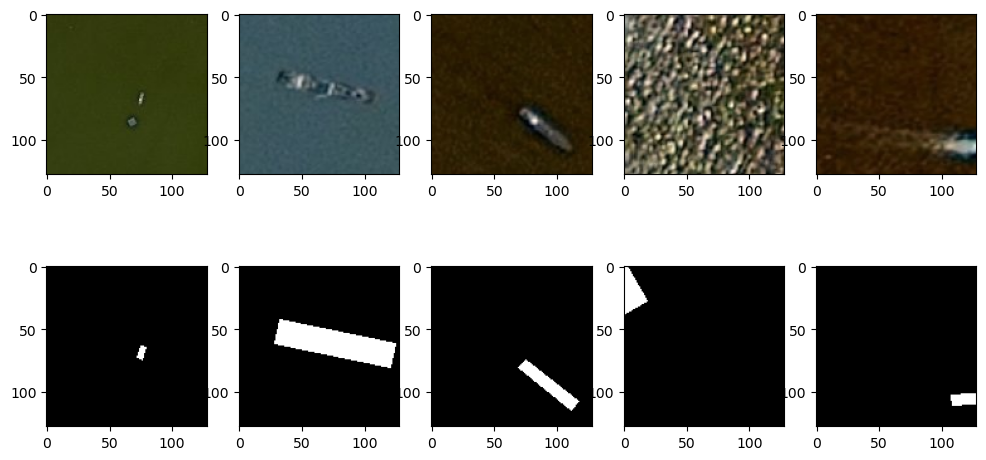

In [31]:
fig, axs = plt.subplots(2, 5,figsize=(12, 6))
for i in range(5):
    img, mask = trainAirbusShipDataset.getranditem()
    axs[0][i].imshow(img)
    axs[1][i].imshow(mask, cmap="gray")
    print(mask.sum())
fig.show()

## 3. Check valid samples

In [32]:
validAirbusShipDataset = AirbusShipDataset("train_v2",
                                           val_imgs[:], 
                                           f"{ROOT_DIR}/train_ship_segmentations_v2.csv", 
                                           transform = None,
                                           train=True,
                                           preprocessing_fn=get_preprocessing(preprocess_input),
                                           augmentation=get_validation_augmentation(),
                                          )

17.0
3172.0
875.0
17.0
11.0


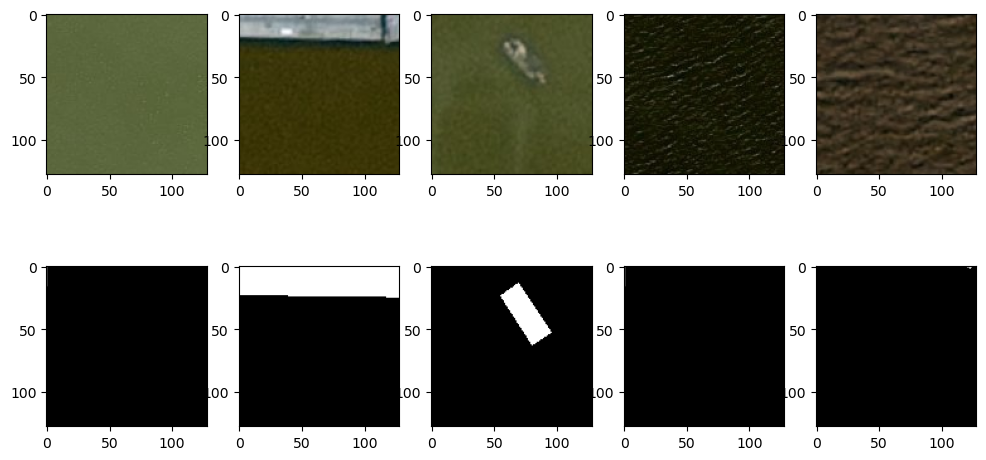

In [33]:
fig, axs = plt.subplots(2, 5,figsize=(12, 6))
for i in range(5):
    img, mask = validAirbusShipDataset.getranditem()
    axs[0][i].imshow(img)
    axs[1][i].imshow(mask, cmap="gray")
    print(mask.sum())
fig.show()

# Model training

## 1. Specify model architecture and run fit

Basic idea of model training - to use U-net with encoder weights (transfer learning), then freeze encoder and train only decoder part. Once it converges try to unfreeze leyer-by-layer from last to the first in encoder

### Spoiler

Model training takes much GPU time which is limited at Kaggle. There are some experiments to find out coverges speed, but setting high lr is not a panacea

In [34]:
BATCH_SIZE = 128
LR = 3e-3
EPOCHS = 2

n_classes = 1
activation = 'sigmoid'
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation, encoder_weights='imagenet', encoder_freeze=True)

44107200/44107200 [==============================] - 0s 0us/step


In [35]:
from keras import backend as K

from keras import backend as K
import numpy as np
import tensorflow as tf
from scipy.ndimage import distance_transform_edt as distance


def calc_dist_map(seg):
    res = np.zeros_like(seg)
    posmask = seg.astype(np.bool)

    if posmask.any():
        negmask = ~posmask
        res = distance(negmask) * negmask - (distance(posmask) - 1) * posmask

    return res


def calc_dist_map_batch(y_true):
    y_true_numpy = y_true.numpy()
    return np.array([calc_dist_map(y)
                     for y in y_true_numpy]).reshape(y_true.shape).astype(np.float32)


def surface_loss_keras(y_true, y_pred):
    y_true_dist_map = tf.py_function(func=calc_dist_map_batch,
                                     inp=[y_true],
                                     Tout=tf.float32)
    multipled = y_pred * y_true_dist_map
    return K.mean(multipled)


class MixedLoss(nn.Module):
    def __init__(self, dc_loss=sm.losses.DiceLoss(), focal_loss=sm.losses.BinaryFocalLoss()):
        super().__init__()
        self.dc_loss = dc_loss
        self.focal_loss = focal_loss
        
    def __call__(self, gt, pr):
#         return - tf.math.log(self.dc_loss.__call__(gt, pr)) + self.focal_loss.__call__(gt, pr)
        return surface_loss_keras(gt, pr)

In [36]:
# from keras.models import load_model
# model.load_weights('/kaggle/input/airbus-models/best_model_24_05876_val.h5')

In [37]:
optim = keras.optimizers.Adagrad(LR)
alpha = 1.
total_loss = sm.losses.DiceLoss()
# total_loss = MixedLoss()
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.losses.DiceLoss(), sm.losses.BinaryFocalLoss(alpha)]

model.compile(optim, total_loss, metrics)

In [38]:
train_dataset = trainAirbusShipDataset
valid_dataset = validAirbusShipDataset

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
    tf.keras.callbacks.TensorBoard(update_freq="batch")
]

In [ ]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_dataloader, 
        steps_per_epoch=len(train_dataloader), 
        epochs=EPOCHS, 
        callbacks=callbacks, 
        validation_data=valid_dataloader, 
        validation_steps=len(valid_dataloader),
    )

## Experiments

I have experimented with training data, losses and training procedures.

### Training data

At first I have tried to train a model with 768x768 images. The bottleneck here was batch_size (which is 2 or 4 without out-of-memory error) that makes training so long. After that I brought to idea of spliting initial images into 128x128 images which allows to increase batch size up to 128. With some cleaning (remove low ship-pixels proportion images - < 30 pixels) it takes ~30 mins for epoch. The best model was trained for 4 epochs that took ~2.5 hours (with validation part) and best model is undertrained. I have tried to make cleaning more rough (<50 pixels), but valid loss converged much slower even for 25 epochs, however it still goes down as train loss. For one epoch it took 7-10 mins without validation, so for training 25_epoch it took ~4 hours. I guess it might be reduced once I specified higher learning rate at the very beginning. I set lr=3e-4 and I had to increase it after each 5 epochs 3 times.

### Losses

There is basic DiceLoss which is ok to boost IoU score. Since there is pixels-imbalance there is binary focal loss metric. I did some experiments to combine these two metrics but it coverges much slower that pure DiceLoss despite of magnitude parameter. Also boosting Focal loss doesn't lead to straightforward IoU increase in this case.

The alernative is using [boundary loss](https://github.com/LIVIAETS/boundary-loss) that started to boost IoU score much faster than DiceLoss(0.11 vs 0.07 at 50-th batch). Nevertheless, after 2-4 epochs validation IoU was 40-50 and improvements slowed down.

Also I searched for other notebooks and found out FocalLoss - log(DiceLoss) but it didnt work nice, I just was curious whether non-monotonic loss might help someone - seems that no 

### Training procedures

Here is no magic. I just proceeded training once model didn't converge. Also I have tried to pretrain model on 7-10 mins dataset to show images with more ship-pixels and then go back to 30 mins dataset. It performed not better then pure 4-epochs dice loss training procedure

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model.save_weights('25-dice-small_train+2-usual_3e-3.h5')

# Model evaluations 

In [39]:
from keras.models import load_model

scores = {}
for model_path in os.listdir('/kaggle/input/airbus-models'):
    if model_path not in scores.keys():
        print(model_path)
        model.load_weights(os.path.join('/kaggle/input/airbus-models', model_path))
        print(f"Evaluating {model_path}...")
        scores[model_path] = model.evaluate(valid_dataloader)

best_model.h5
Evaluating best_model.h5...
35/35 [==============================] - 236s 7s/step - loss: 0.2666 - iou_score: 0.6029 - dice_loss: 0.2666 - binary_focal_loss: 0.0201
best_model (2)_maybe_best.h5
Evaluating best_model (2)_maybe_best.h5...
35/35 [==============================] - 211s 6s/step - loss: 0.1817 - iou_score: 0.6957 - dice_loss: 0.1817 - binary_focal_loss: 0.0452
best_model (3).h5
Evaluating best_model (3).h5...
35/35 [==============================] - 234s 7s/step - loss: 0.5053 - iou_score: 0.3808 - dice_loss: 0.5053 - binary_focal_loss: 0.1010
best_model_24_05876_val.h5
Evaluating best_model_24_05876_val.h5...
35/35 [==============================] - 217s 6s/step - loss: 0.2655 - iou_score: 0.5876 - dice_loss: 0.2655 - binary_focal_loss: 0.0463
25-dice-small_train2-usual_3e-3.h5
Evaluating 25-dice-small_train2-usual_3e-3.h5...
35/35 [==============================] - 211s 6s/step - loss: 0.2186 - iou_score: 0.6506 - dice_loss: 0.2186 - binary_focal_loss: 0.0592

In [41]:
model.load_weights("/kaggle/input/airbus-loads/best_model (1).h5")
model.evaluate(valid_dataloader)

35/35 [==============================] - 210s 6s/step - loss: 0.1992 - iou_score: 0.6775 - dice_loss: 0.1992 - binary_focal_loss: 0.0457


[0.19915038347244263,
 0.6774652600288391,
 0.19915038347244263,
 0.045681409537792206]

Airbus-models dataset contains model I've obtained during experiments

## Models

### best_model.h5
Trained for 2 epochs with Adam optimizer and DiceLoss loss


### best_model (2)_maybe_best.h5
Trained for 4 epochs with Adam optimizer and DiceLoss loss

### best_model (3).h5
Experimes with another losses

### best_model_24_05876_val.h5

25-dice-small_train.h5 model that is stopped at 24 epoch. 25-th epoch suprisingly dropped validation metric, maybe because of setting high lr 

### 25-dice-small_train2-usual_3e-3.h5

Proceed 25-dice-small_train.h5 model with 2 epochs from best_model.h5

### 25-dice-small_train.h5

Trained for 25 epochs with small train daat (images that contains >= 50 ship pixels. Good train IoU (>70), but poor validation despite validation is diminishing at each epoch

### best_model (1).h5

3 epochs

# Inference part

## 1. Check valid samples prediction

4/4 [==============================] - 7s 1s/step


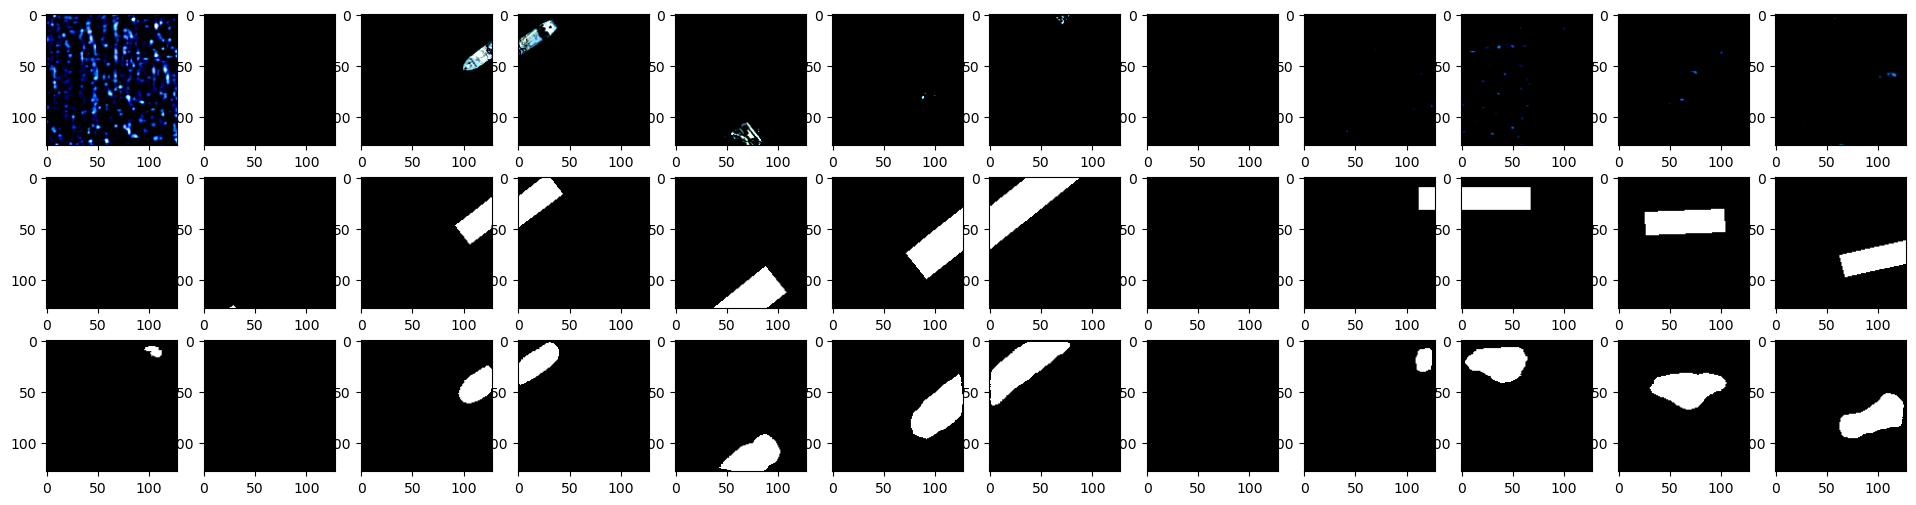

In [40]:
fig, axs = plt.subplots(3, 12,figsize=(24, 6))

batch, mask = valid_dataloader[0]
threshold = 0.5
pred = model.predict(batch)
pred[pred >= threshold] = 1
pred[pred < threshold] = 0

for i in range(12):
    axs[0][i].imshow(batch[i])
    axs[1][i].imshow(mask[i], cmap="gray")
    axs[2][i].imshow(np.squeeze(pred)[i], cmap="gray")

fig.show()

## 2. Inference code for test file

In [56]:
class TestDataset():
    
    def __init__(self, root_paths, paths, preprocessing_fn=None, split_into_squares=False, limit=None):
        self.root_paths = root_paths
        self.paths = paths[:limit] if split_into_squares == False else [(x,i,j) for x in paths[:limit] for i in range(6) for j in range(6)] 
        self.preprocessing_fn = preprocessing_fn
       
    def __len__(self):
        return len(self.paths)
    
    def getranditem(self):
        ImageId, qi, qj = self.paths[randrange(self.__len__())]
         
        img_path = f"{ROOT_DIR}/{self.root_paths}/{ImageId}"
        image = cv2.imread(img_path)

        step = 128
        patch_img = patchify(image, (step,step, 3), step=step)
        return patch_img[qi][qj][0], (ImageId, qi, qj)
    
    def __getitem__(self, idx):
        ImageId, qi, qj = self.paths[idx]
#         if not self.masks.empty:
#             img_masks = self.masks.loc[self.masks['ImageId'] == ImageId, 'EncodedPixels'].tolist()
#             all_masks = rle_decoder(img_masks, (768, 768))

        img_path = f"{ROOT_DIR}/{self.root_paths}/{ImageId}"
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        
        step = 128
        patch_img = patchify(image, (step,step, 3), step=step)
        image = patch_img[qi][qj][0]                
        
        if self.preprocessing_fn is not None:
            image = np.array(image)
            sample = self.preprocessing_fn(image = image)
            image = sample['image']
        
#         if not self.train:
#             x =  image.transpose([2, 0, 1]).astype(np.float32)
#             x = x.astype(np.float32)
#             tf.cast(x, tf.float32)
#             return x, ImageId
        
        image = image.astype(np.float32)
        tf.cast(image, tf.float32)
        return image, (ImageId, qi, qj)

In [80]:
def make_up_prediction(predictions):
    num_images = predictions.shape[0] // 36
    images_batch = predictions.squeeze().reshape((num_images, 36,128,128))
    result = []
#     print(images_batch.shape)
    for batch in images_batch:
#         print(batch.shape)
        img = unpatchify(batch.reshape(6, 6, 128, 128), (768, 768))
        threshold = 0.5
        img[img >= threshold] = 1
        img[img < threshold] = 0
        result.append(img)
    return result

In [58]:
testAirbusShipDataset = TestDataset("test_v2",
                                    os.listdir(test_folder), 
                                    preprocessing_fn=get_preprocessing(preprocess_input),
                                    split_into_squares = True,
                                    limit=100
                                    )

In [59]:
test_dataloader = Dataloder(testAirbusShipDataset, batch_size=36, shuffle=False)
predictions = model.predict(test_dataloader)

100/100 [==============================] - 142s 1s/step


In [60]:
predictions.shape

(3600, 128, 128, 1)

In [72]:
predictions.squeeze().reshape((100, 36,128,128)).shape

(100, 36, 128, 128)

In [82]:
maked_up = make_up_prediction(predictions)
len(maked_up), maked_up[0].shape

(100, (768, 768))

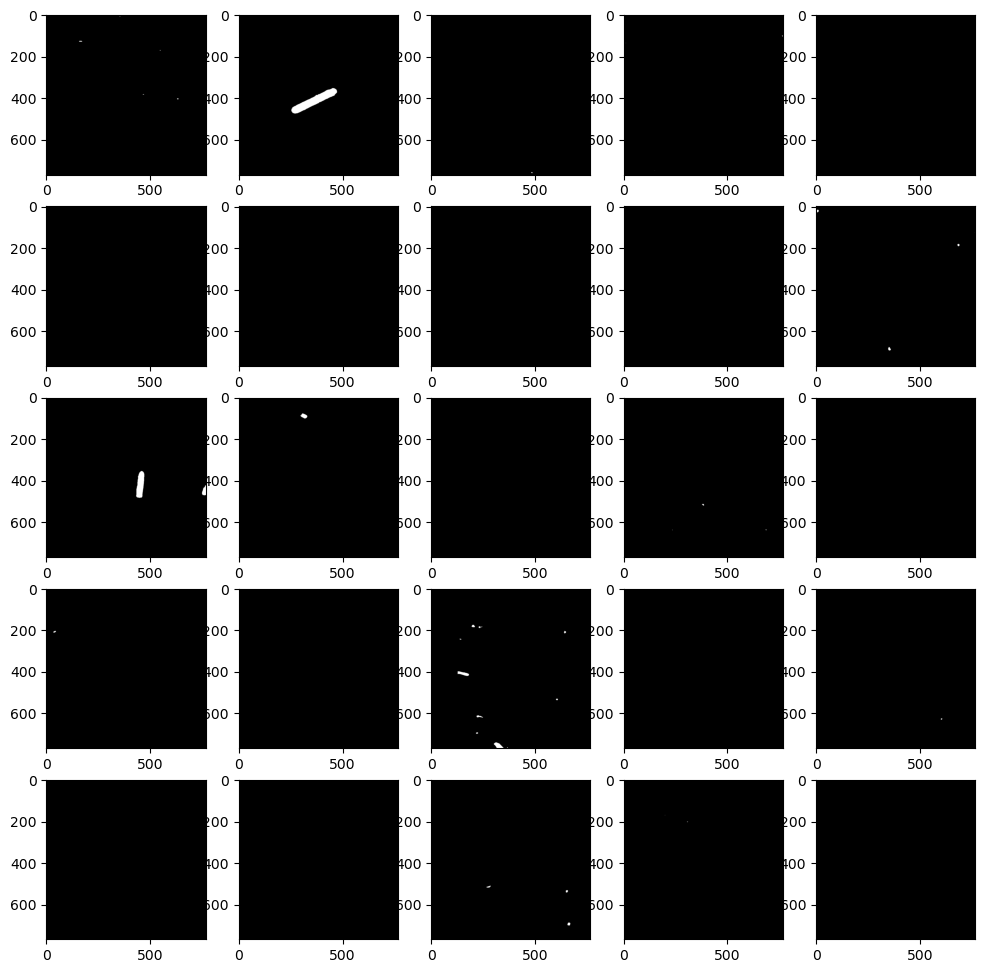

In [87]:
fig, axs = plt.subplots(5, 5,figsize=(12, 12))

for i in range(25):
    axs[i // 5][i % 5].imshow(maked_up[i], cmap="gray")

fig.show()

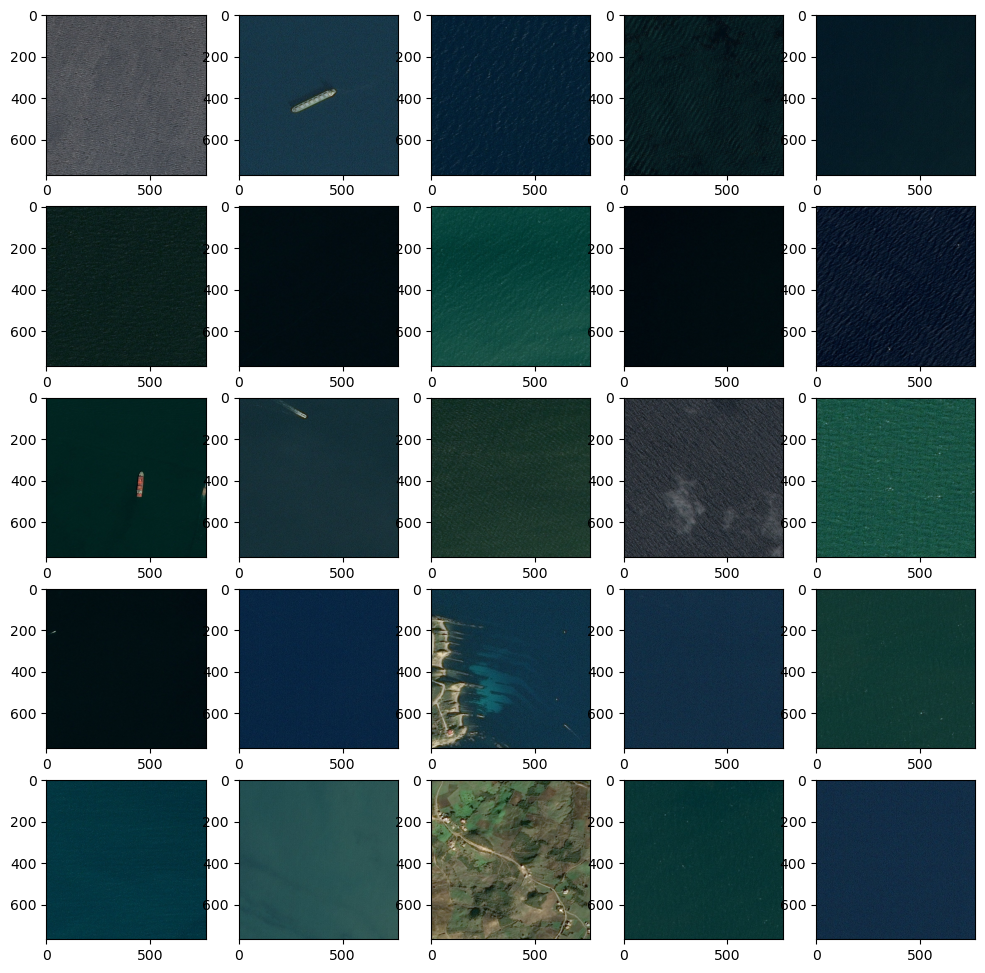

In [90]:
fig, axs = plt.subplots(5, 5,figsize=(12, 12))

for i in range(25):
    im = PIL.Image.open(os.path.join(test_folder, os.listdir(test_folder)[i]))
    axs[i // 5][i % 5].imshow(im)

fig.show()

In [ ]:
submission = []
threshold = 0.5

with torch.no_grad():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for batch_idx, (images, paths) in tqdm(enumerate(testLoaderAirbusShipDataset)):
        images = images.to(device)
        predictions[predictions >= threshold] = 1
        predictions[predictions < threshold] = 0

        for pred,path in zip(predictions,paths):
            img_array = pred.squeeze().cpu().numpy()
            submission.append({"ImageId":path,"EncodedPixels":rle_encoder(img_array)})

